## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

# Get the DM halo mass (and the number of DM particles for sample).
commah_output = commah.run('Planck13', zi=0, Mi=1e8, z=0)
Mz = commah_output['Mz'][0,0]*Msun
num_DM = math.floor(Mz / DM_mass)

# Get the parameters of the halo.
c_200 = commah_output['c'][0,0]
# R_200 = 

ic(commah_output)

ic(f'{Mz/Msun:.2e}')
ic(f'{c_200:.2e}')

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir, origin_offset=0.):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('Planck13', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian DM_coords.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z)) + origin_offset

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)


# Generate 2 NFW halos: 10^12 host halo and 10^8 subhalo some offset away.
subhalo_offset = np.array([0, 40, 8])*kpc
with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir),
        repeat(subhalo_offset)

    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Run scripts.

### all_sky sim type tests.

In [ ]:
!python simulation_analytical.py \
-d L025N752/DMONLY/SigmaConstant00/all_sky_analytical_tests \
-st all_sky \
--MW_halo \
--no-VC_halo \
--no-AG_halo

In [ ]:
!python make_simulation_parameters.py \
--sim_dir L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
--sim_type all_sky \
--healpix_nside 2 \
--nu_mass_start 0.01 \
--nu_mass_stop 0.3 \
--nu_mass_num 100 \
--nu_sim_mass 0.3 \
--p_start 0.01 \
--p_stop 400 \
--p_num 10_000 \
--init_x_dis 8.5 \
--z_int_shift 0.1 \
--z_int_stop 4 \
--z_int_num 100 \
--int_solver RK23 \
--CPUs_precalculations 128 \
--CPUs_simulations 128 \
--memory_limit_GB 224 \
--DM_in_cell_limit 10_000

In [ ]:
from shared.preface import *

arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/initial_velocities.npy')
print(arr.itemsize*arr.size/1e6)
print(arr.shape)

In [ ]:
print(os.getcwd())

In [ ]:
!python simulation_analytical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
--MW_halo \
--no-VC_halo \
--no-AG_halo

In [ ]:
from shared.preface import *
arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/number_densities_analytical_all_sky.npy')
print(arr.shape)

In [ ]:
!python simulation_numerical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
-mg 12.0 \
-mr 0.6 \
-hn 1

### single_halos & benchmark sim type tests.

In [ ]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark -st single_halos --MW_halo --no-VC_halo --no-AG_halo

In [ ]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo -st single_halos -mg 12.0 -mr 0.6 -hn 1

## Load, transform and plot simulation outputs.

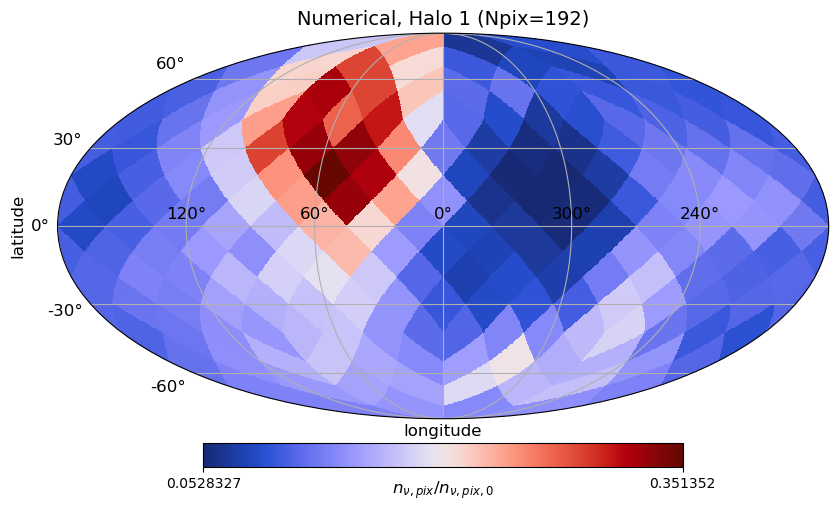

In [1]:
from shared.preface import *
from shared.shared_functions import *

class analyze_simulation_outputs(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical_single_halos.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1):
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )


    def plot_all_sky_map(self, nu_mass_eV, sim_method, halo=None):

        savefig_args = dict(
            bbox_inches='tight'
        )
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        # Automatic.
        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        # Manual.
        # Nside = 4
        # Npix = 12*(Nside**2)
        # pix_sr = 4*Pi/Npix
        # N0_pix = N0/Npix

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[:,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix

            healpix_map = etas_nu

            hp.newvisufunc.projview(
                healpix_map,
                coord=['G'],
                title=f'Analytical (Npix={Npix}, {nu_mass_eV}eV)',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro',
                # cbar_ticks=[],
                # show_tickmarkers=True,
            )

            plt.savefig(
                f'{self.fig_dir}/all_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map

        if sim_method == 'numerical':

            from astropy import units as u
            from astropy.coordinates import SkyCoord

            def spherical_to_galactic(polar_angles, azimuthal_angles, unit='radian'):
                """
                Convert spherical coordinate angles (polar and azimuthal angles) to
                galactic latitude and longitude.

                Parameters
                ----------
                polar_angles : numpy.array
                    Array of polar angles (theta).
                azimuthal_angles : numpy.array
                    Array of azimuthal angles (phi).
                unit : str, optional
                    Unit of the input angles, either 'radian' (default) or 'degree'.

                Returns
                -------
                numpy.array
                    Array of galactic latitude and longitude.
                """

                if unit == 'radian':
                    # Convert angles from radians to degrees
                    polar_degrees = np.rad2deg(polar_angles)
                    azimuthal_degrees = np.rad2deg(azimuthal_angles)
                elif unit == 'degree':
                    polar_degrees = polar_angles
                    azimuthal_degrees = azimuthal_angles
                else:
                    raise ValueError("Invalid unit. It must be either 'radian' or 'degree'.")

                # Convert to equatorial coordinates (RA, Dec)
                ra = azimuthal_degrees
                dec = 90 - polar_degrees

                # Create SkyCoord object for the equatorial coordinates
                equatorial_coords = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='deg')

                # Convert to galactic coordinates (l, b)
                galactic_coords = equatorial_coords.transform_to('galactic')

                # Get galactic latitude and longitude
                galactic_latitude = galactic_coords.b.deg
                galactic_longitude = galactic_coords.l.deg

                # Combine galactic latitude and longitude into a single array
                galactic_coordinates = np.vstack((galactic_latitude, galactic_longitude)).T

                return galactic_coordinates

            halo_params = np.load(
                glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
            )
            # Mvir = halo_params[halo-1,1]
            
            # Initial pixel array.
            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix
            healpix_map = etas_nu[halo-1,:]
            
            # Angles from initialization.
            # old_angles = np.load(f'{self.sim_dir}/all_sky_angles.npy')
            # phis, thetas = old_angles[:, 0], old_angles[:, 1]

            # gal_coords = spherical_to_galactic(thetas, phis)
            # glat_deg, glon_deg = gal_coords[:, 0], gal_coords[:, 1]

            # Convert old angles to pixel indices.
            # init_indices = hp.ang2pix(Nside, thetas, phis)

            # Determine new angles, which are galactic latitude and longitude.
            # glat = Pi/2. - thetas
            # glat = thetas - Pi/2.

            # phi_cond1 = (phis <= Pi)
            # phis[phi_cond1] = Pi - phis[phi_cond1]
            # phis[phi_cond1] = phis[phi_cond1] - Pi
            # phis[phi_cond1] += Pi

            # phi_cond2 = (phis > Pi) & (phis <= 2*Pi)
            # phis[phi_cond2] = 3*Pi - phis[phi_cond2]
            # phis[phi_cond2] = phis[phi_cond2] - 3*Pi
            # phis[phi_cond2] -= Pi
            # glon = Pi/2 - phis

            # Convert new angles to pixel indices.
            # hp_thetas, hp_phis = np.rad2deg(glon), np.rad2deg(glat)
            # hp_thetas, hp_phis = glon_deg, glat_deg
            # new_indices = hp.ang2pix(Nside, hp_thetas, hp_phis, lonlat=True)

            # Initialize an empty array for the rearranged Healpix values
            # new_healpix_map = np.zeros_like(healpix_map)

            # Rearrange the Healpix values based on the new pixel indices
            # for i, old_index in enumerate(init_indices):
                # new_healpix_map[new_indices[i]] = healpix_map[old_index]

            # hp.mollview(healpix_map, cmap=cc.cm.CET_D1A)

            # Create a rotator object
            rot_angles = [Pi,0,0]
            r = hp.Rotator(
                rot=rot_angles, deg=False, inv=False, eulertype='ZYX'
            )

            # Rotate the pixel array
            healpix_map_rotated = r.rotate_map_pixel(healpix_map)

            hp.newvisufunc.projview(
                healpix_map,
                # healpix_map_rotated,
                coord=['G'],
                # title=f'Numerical, Halo {halo} Mvir={10**Mvir:.2e}Msun (Npix={Npix})',
                title=f'Numerical, Halo {halo} (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro'
                # cbar_ticks=[],
                # show_tickmarkers=True,
            )

            plt.savefig(
                f'{self.fig_dir}/all_sky_map_numerical_halo{halo}_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map


    def plot_neutrinos_inside_Rvir(self):

        #? evidence to show at what redshift clustering happens?
        
        # All positions and velocities across redshifts.
        pos = self.vectors_analytical[...,0:3]
        vel = self.vectors_analytical[...,3:6]

        # Radii and velocity magnitudes.
        rad = np.sqrt(np.sum(pos**2, axis=-1))
        mag = np.sqrt(np.sum(vel**2, axis=-1))
        ic(mag.shape)

        # Escape velocity.
        MW_esc = 550  # km/s
        esc_cond = (mag*(kpc/s)/(km/s) <= MW_esc)
        _, esc_num = np.unique(esc_cond, return_counts=True, axis=0)
        # esc = np.where()
        # zeds_esc_nr = [len(arr) for arr in esc]


# print(np.load(
#     'L025N752/DMONLY/SigmaConstant00/all_sky_low_res/halo_batch_1e+12.0_pm0.6Msun_params.npy'
# ))
# print(np.load(
#     'L025N752/DMONLY/SigmaConstant00/all_sky_high_res/halo_batch_1e+12.0_pm0.6Msun_params.npy'
# ))

# Analysis.plot_neutrinos_inside_Rvir()

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_analytical_tests'
objects = (
    # 'NFW_halo', 
    # 'box_halos', 
    'analytical_halo'
)
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)
healpix_map = Analysis.plot_all_sky_map(
    nu_mass_eV=0.3, sim_method='analytical', halo=None
)
# '''

sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_TEST'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)
halo_num = 1
for i in range(1,halo_num+1): 
    healpix_map = Analysis.plot_all_sky_map(
        nu_mass_eV=0.3, sim_method='numerical', halo=i
    )

#? testing inpact of quadrupole...